In [1]:
import angle_extraction as aex
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy,os
from scipy.optimize import minimize

Final fit:
 Center: (821.160439, 674.368559)
 Radius: 338.006616
 RMS residual: 0.423559
 Points kept: 77, removed: 22


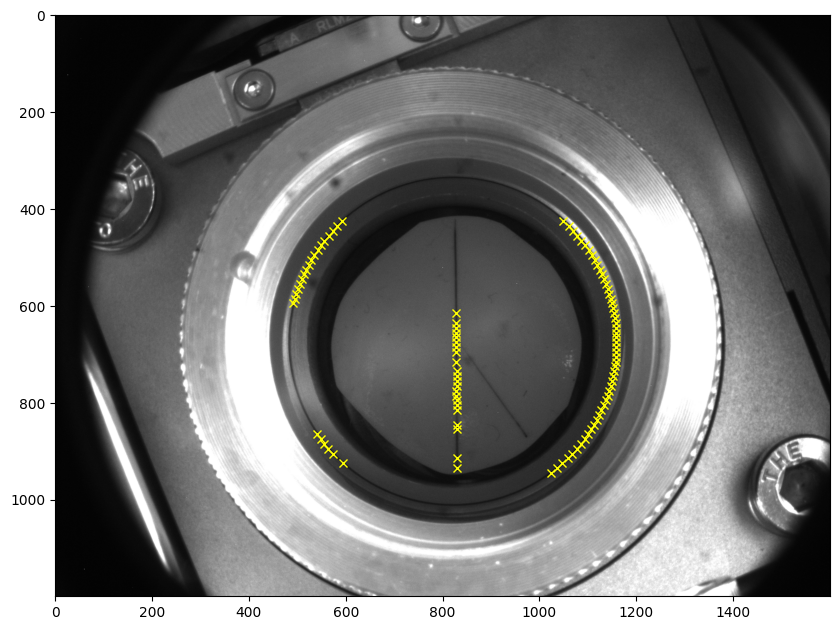

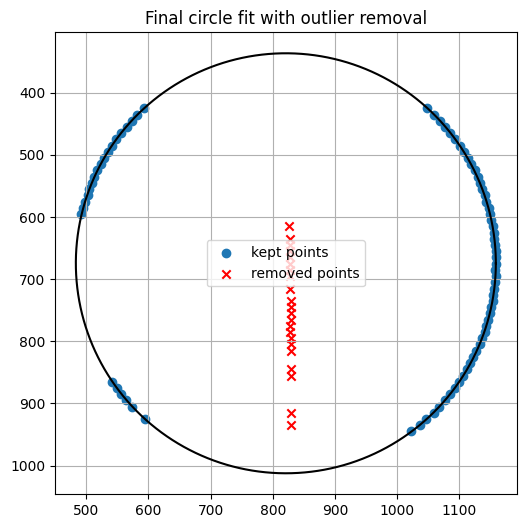

In [2]:
img_number="00023"

image_file_name=f"C:\\Users\\Jason.Bane\\Documents\\Nautilus\\DOE_stage\\code_trials\\images\\Image{img_number}.BMP"

image = cv2.imread(image_file_name)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges= aex.horizontal_edges(gray_image, resolution=10, plot=1, verbose=False)

if len(edges)>2:
    center_info =aex.Center_Radius_iterations(edges, plot=True, verbose=True)

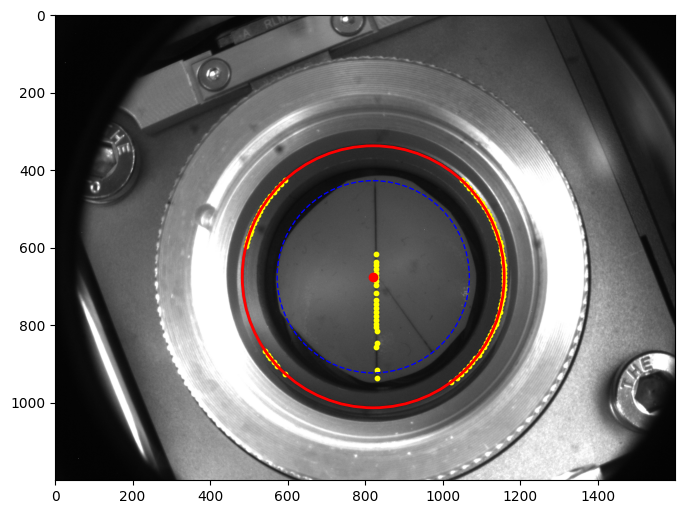

In [3]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))   
ax.scatter(edges[:,0], edges[:,1], color='yellow', s=10, label='Detected Edges')

cx, cy, r, rms = center_info[:4]
circle = plt.Circle((cx, cy), r, color='red', fill=False, linewidth=2, label='Fitted Circle')
ax.add_artist(circle)

inner_circle_rad=   r-90
inner_circle = plt.Circle((cx, cy), inner_circle_rad, color='blue',
                          fill=False, linestyle='--', linewidth=1, label='Inner Boundary')


ax.add_artist(inner_circle)
ax.plot(cx, cy, 'ro', label='Circle Center')

In [31]:
#hard coded values to define the image and other parameters
H_limit_hard = [int(cx-inner_circle_rad), int(cx+inner_circle_rad)]
V_limit_hard = [int(cy-inner_circle_rad), int(cy+inner_circle_rad)]

Vertical_limits = [int(cy-r),int(cy+r)]
Horizontal_limits = [int(cx-r),int(cx+r)]

In [187]:
def horizontal_scan_for_center_peaks(image, resolution=10, center_info=None, plot=1, verbose=False):
    
    #check if image is color or grayscale
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    
    if center_info is None:
        print("No center info provided.")
        edges=aex.horizontal_edges(gray_image, resolution=resolution, plot=0, verbose=False)
        center_info =aex.Center_Radius_iterations(edges, plot=False, verbose=False)

    cx, cy, r, rms = center_info[:4]
    inner_circle_rad=   r-90
    H_limit = [int(cx-inner_circle_rad), int(cx+inner_circle_rad)]
    V_limit = [int(cy-inner_circle_rad), int(cy+inner_circle_rad)]

    Horizontal_limits = [int(cx-r),int(cx+r)]
    Vertical_limits = [int(cy-r),int(cy+r)]
    

    if plot:
      fig,ax = plt.subplots(figsize=(10,4))
      ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      ax.plot(cx, cy, 'ro', label='Circle Center')
      inner_circle = plt.Circle((cx, cy), inner_circle_rad, color='blue',
                          fill=False, linestyle='--', linewidth=1, label='Inner Boundary')
      ax.add_artist(inner_circle) 
      ax.grid()


    All_peaks = []
    # start scanning lines
    for j,y in enumerate(range(V_limit[0],V_limit[1], resolution)):

        if verbose:
            print(f"Line {j} at y={y}")

        line_scan = np.max(gray_image[y, :])-gray_image[y,:]

        # calculate left and right limits for the line scan useing circle equation

        square_diff =(np.ceil(inner_circle_rad**2) - (np.floor(y - cy))**2)
        if square_diff <= 0:
            if verbose:
                print(f"Skipping line {j} at y={y} - outside inner circle")
            continue

        left_most = int(cx - np.sqrt(square_diff))
        right_most = int(cx + np.sqrt(square_diff))

        line_scan[:left_most] = line_scan[left_most]
        line_scan[right_most:] =     line_scan[right_most]

        smooth_scan = scipy.signal.savgol_filter(line_scan, window_length=11, polyorder=3)


        if plot:
            ax.hlines(y, H_limit[0], H_limit[1],
                    colors='red', linestyles='dashed', linewidth=1)

        
        if plot > 1:
            
            fig2,ax2 = plt.subplots(figsize=(10,4))
            ax2.plot(line_scan, color="blue",label=f'Line {j} at y={y}')
            ax2.plot(smooth_scan, color="green",label='Smoothed Scan')
            ax2.grid() 
            ax2.legend()
            ax2.set_xlim(Horizontal_limits)

        peaks=[]

        peaks,peak_props = scipy.signal.find_peaks(smooth_scan,
                                                width=[3,200],
                                                prominence=15,
                                                    height=1)

        if verbose:
            print(f"  Found {len(peaks)} peaks at x-positions: {peaks}") 
            for key in peak_props:
                print(f"    {key}: {peak_props[key]}")  


        if len(peaks) > 0:
            if plot > 1:
                ax2.scatter(peaks, line_scan[peaks], color='red', s=50, label='Detected Peaks')
            if plot >= 1:    
                ax.scatter(peaks, np.full_like(peaks, y), color='cyan', s=20, label='Detected Peaks')

        #If more then two peaks are found pick the best two based on prominence
        if len(peaks) > 2:
            prominences = peak_props['prominences']
            top_two_indices = np.argsort(prominences)[-2:]
            peaks = peaks[top_two_indices]


        All_peaks.append(np.column_stack((peaks, np.full_like(peaks, y))))

    return np.vstack(All_peaks)
            

No center info provided.
Line 0 at y=426
Skipping line 0 at y=426 - outside inner circle
Line 1 at y=436
  Found 1 peaks at x-positions: [826]
    peak_heights: [205.32167832]
    prominences: [17.44755245]
    left_bases: [783]
    right_bases: [865]
    widths: [7.07697737]
    width_heights: [196.5979021]
    left_ips: [821.86937299]
    right_ips: [828.94635036]
Line 2 at y=446
  Found 1 peaks at x-positions: [826]
    peak_heights: [212.62937063]
    prominences: [26.90675991]
    left_bases: [809]
    right_bases: [884]
    widths: [7.3622093]
    width_heights: [199.17599068]
    left_ips: [821.7]
    right_ips: [829.0622093]
Line 3 at y=456
  Found 1 peaks at x-positions: [825]
    peak_heights: [217.77855478]
    prominences: [33.51048951]
    left_bases: [771]
    right_bases: [860]
    widths: [7.46349108]
    width_heights: [201.02331002]
    left_ips: [821.9145403]
    right_ips: [829.37803138]
Line 4 at y=466
  Found 1 peaks at x-positions: [826]
    peak_heights: [214.60

C:\Users\Jason.Bane\AppData\Local\Temp\ipykernel_22044\2201387933.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig2,ax2 = plt.subplots(figsize=(10,4))


  Found 2 peaks at x-positions: [829 883]
    peak_heights: [207.57808858 190.80885781]
    prominences: [34.74825175 15.87878788]
    left_bases: [653 866]
    right_bases: [866 914]
    widths: [6.94974624 7.66799802]
    width_heights: [190.2039627  182.86946387]
    left_ips: [825.30217004 879.94004796]
    right_ips: [832.25191627 887.60804598]
Line 33 at y=756
  Found 2 peaks at x-positions: [828 891]
    peak_heights: [203.69230769 192.23310023]
    prominences: [30.52447552 16.84149184]
    left_bases: [647 854]
    right_bases: [854 907]
    widths: [7.49828337 8.9380434 ]
    width_heights: [188.43006993 183.81235431]
    left_ips: [825.2489277  885.85675182]
    right_ips: [832.74721107 894.79479522]
Line 34 at y=766
  Found 2 peaks at x-positions: [829 898]
    peak_heights: [207.65268065 194.98135198]
    prominences: [34.39393939 17.48951049]
    left_bases: [651 868]
    right_bases: [868 919]
    widths: [7.60041198 7.86019548]
    width_heights: [190.45571096 186.23659

array([[ 826,  436],
       [ 826,  446],
       [ 825,  456],
       [ 826,  466],
       [ 826,  476],
       [ 826,  486],
       [ 826,  496],
       [ 827,  506],
       [ 827,  516],
       [ 826,  526],
       [ 827,  536],
       [ 827,  546],
       [ 827,  556],
       [ 827,  566],
       [ 827,  576],
       [ 828,  586],
       [ 827,  596],
       [ 827,  606],
       [ 828,  616],
       [ 828,  626],
       [ 828,  636],
       [ 828,  646],
       [ 829,  656],
       [ 828,  666],
       [ 829,  676],
       [ 828,  686],
       [ 829,  696],
       [ 829,  706],
       [1041,  706],
       [ 829,  716],
       [ 860,  716],
       [ 829,  726],
       [1042,  726],
       [ 829,  736],
       [ 876,  736],
       [ 829,  746],
       [ 883,  746],
       [ 828,  756],
       [ 891,  756],
       [ 829,  766],
       [ 898,  766],
       [ 829,  776],
       [ 904,  776],
       [ 829,  786],
       [ 912,  786],
       [ 828,  796],
       [ 919,  796],
       [ 829,

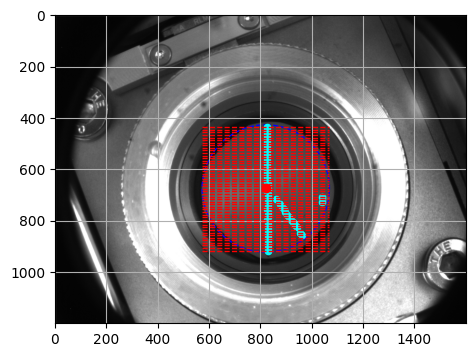

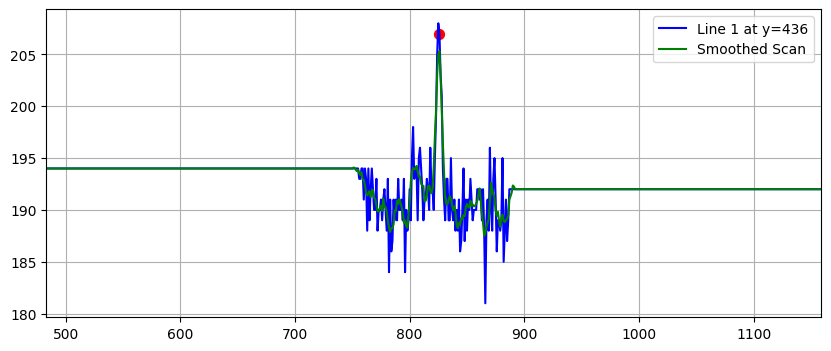

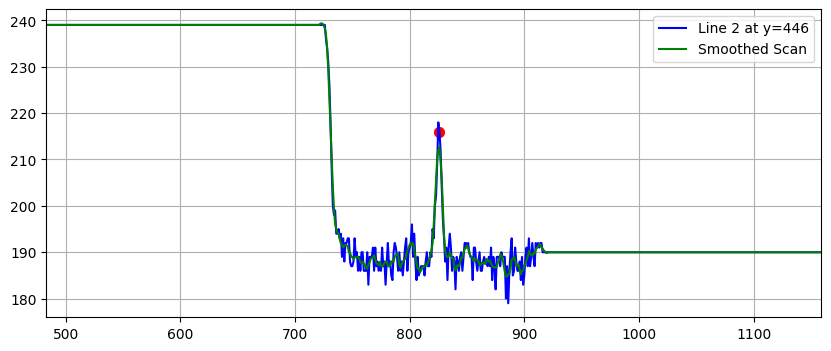

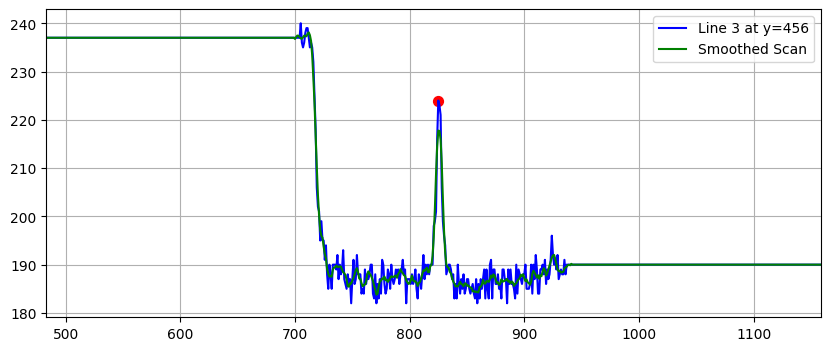

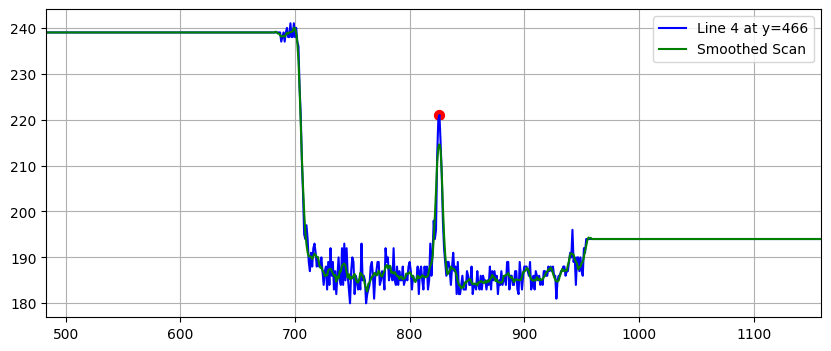

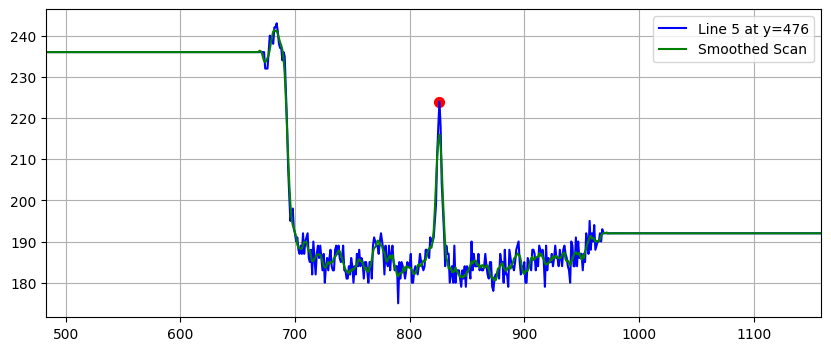

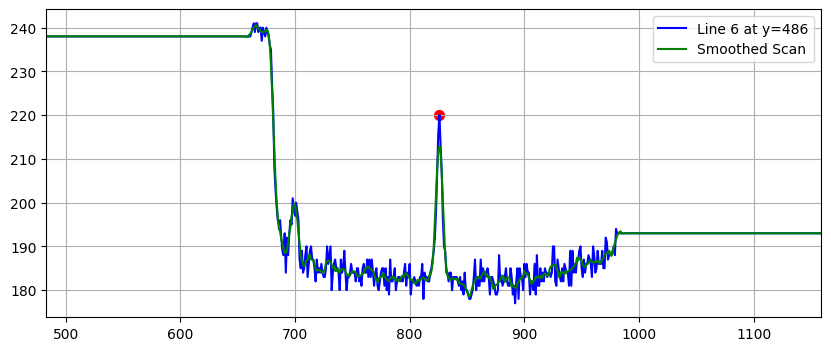

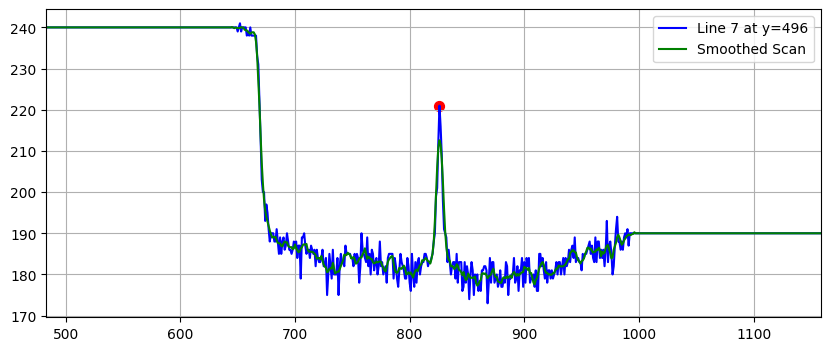

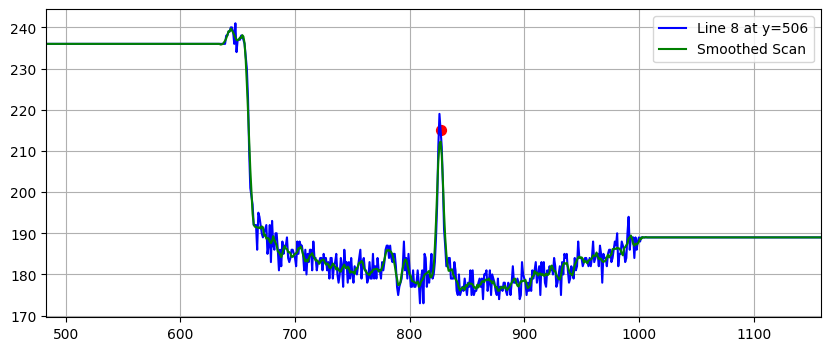

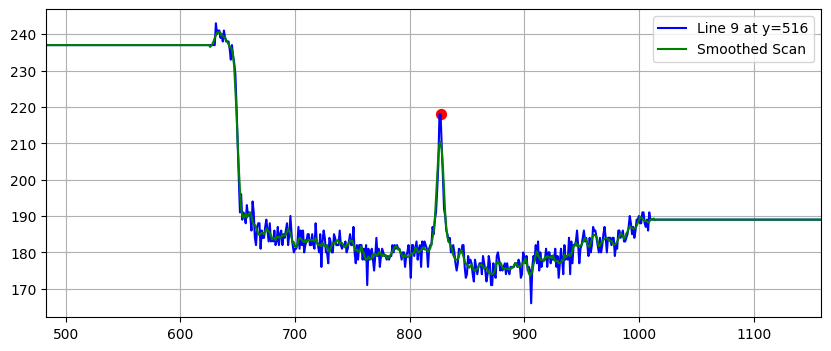

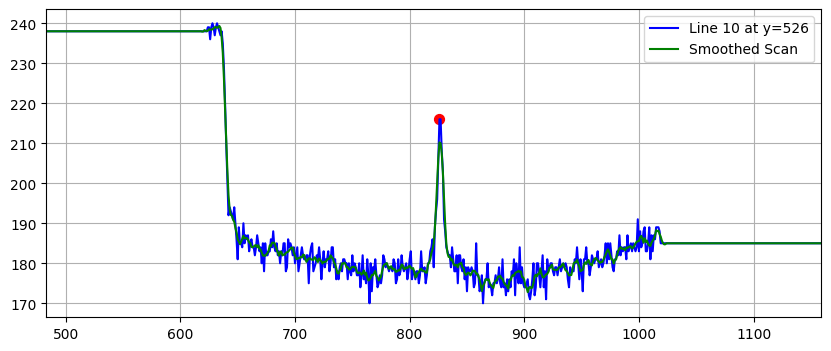

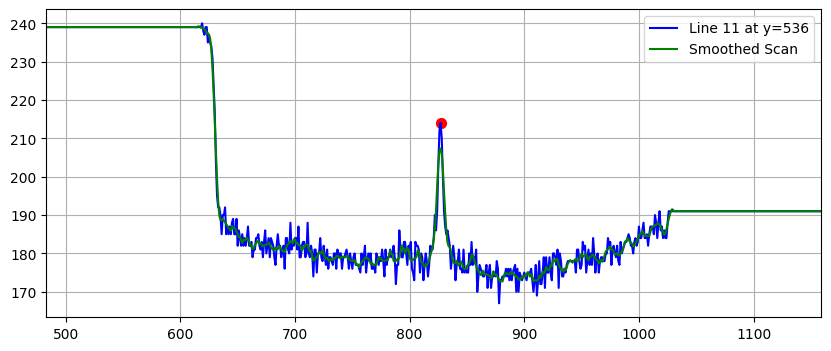

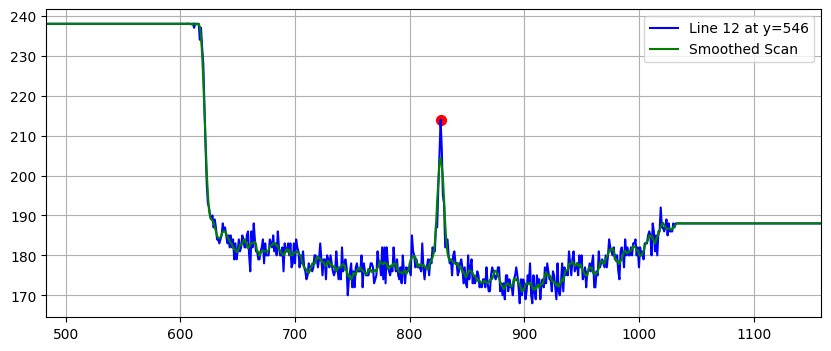

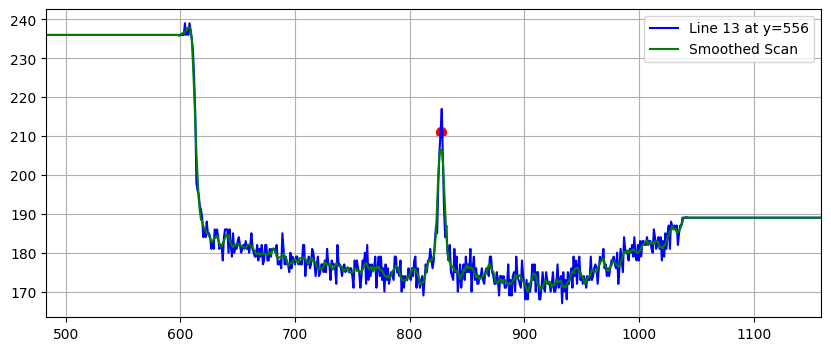

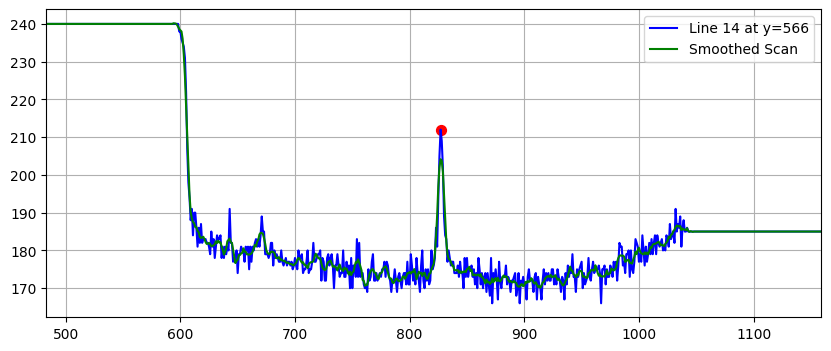

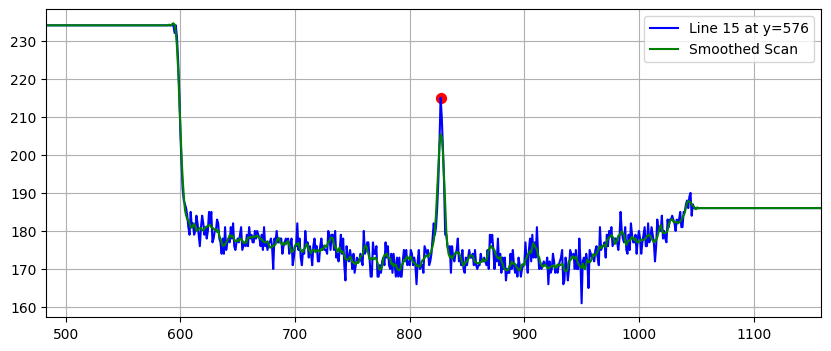

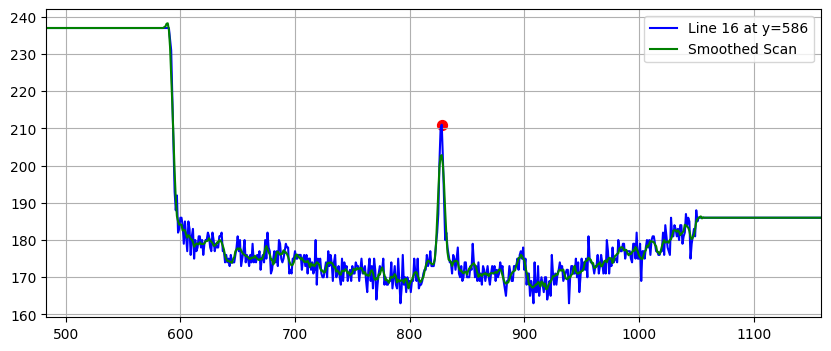

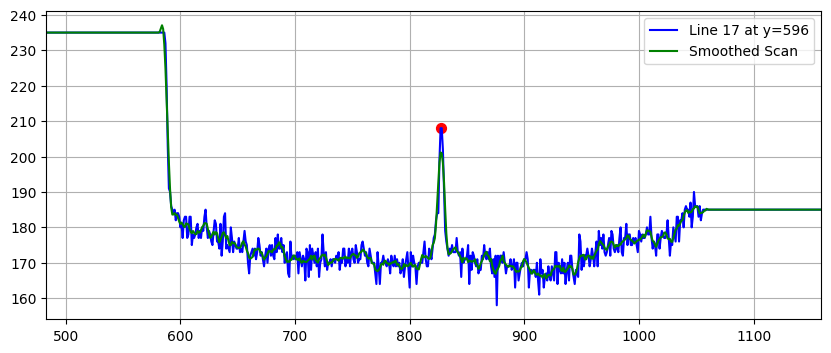

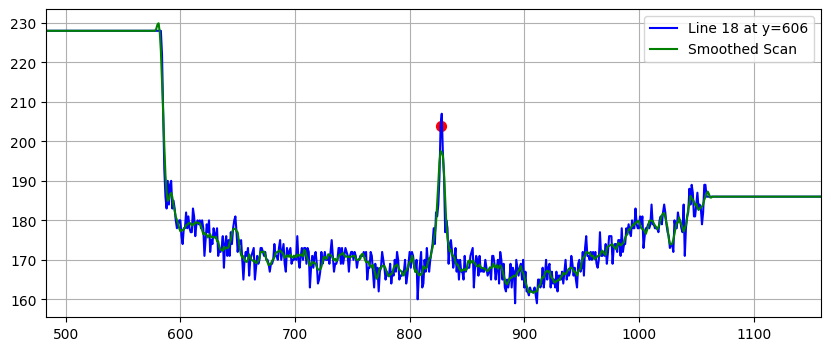

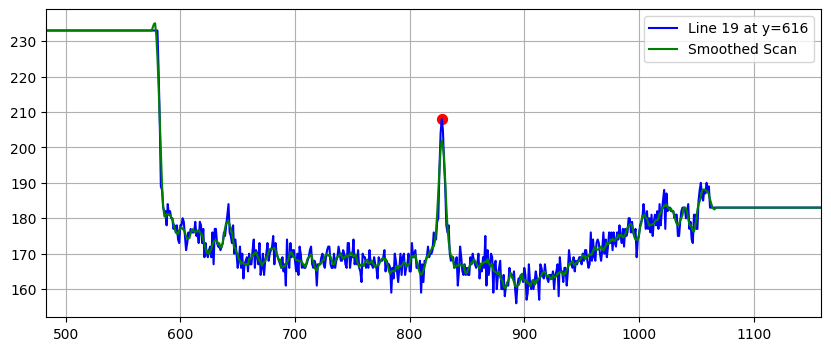

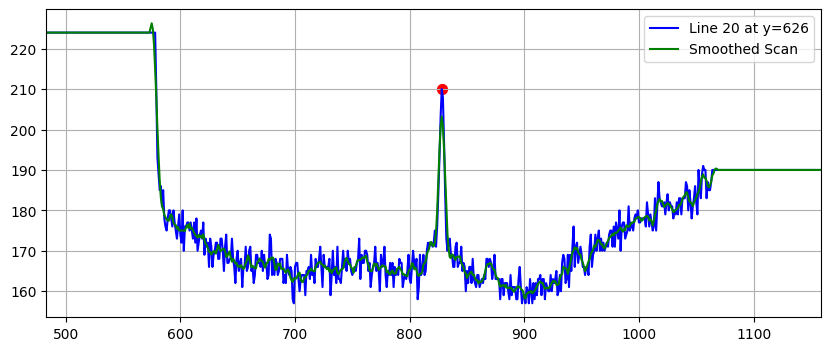

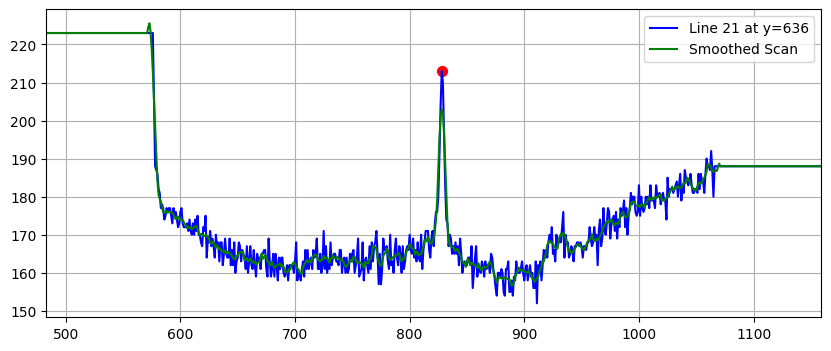

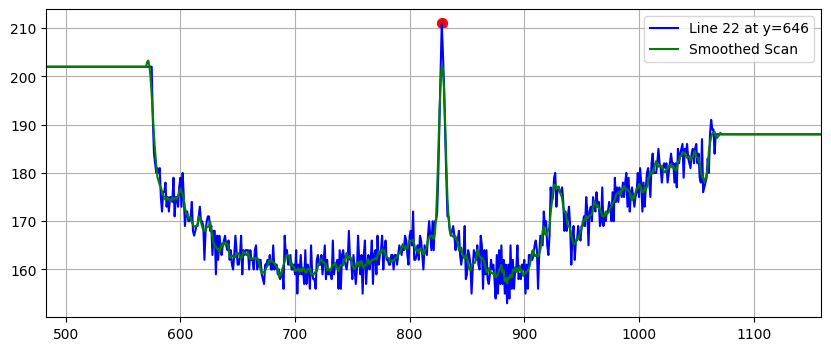

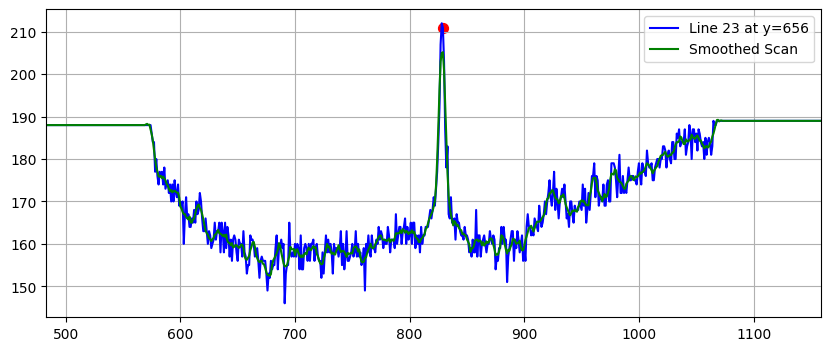

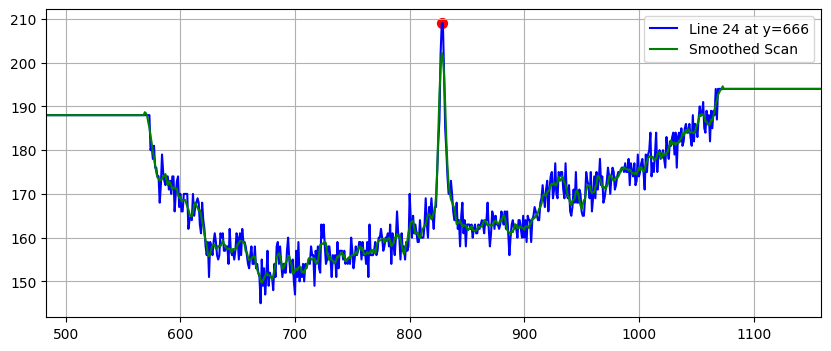

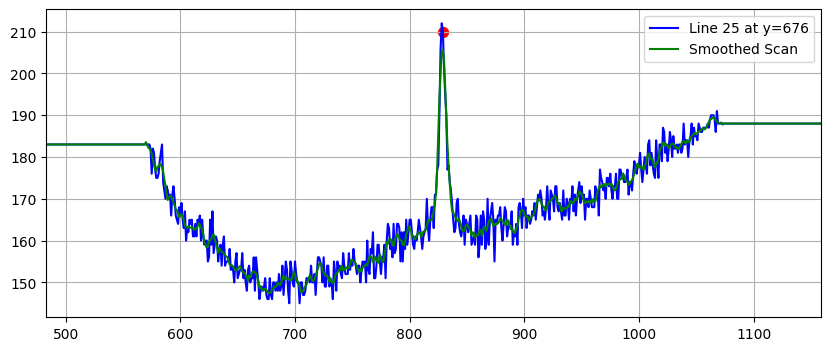

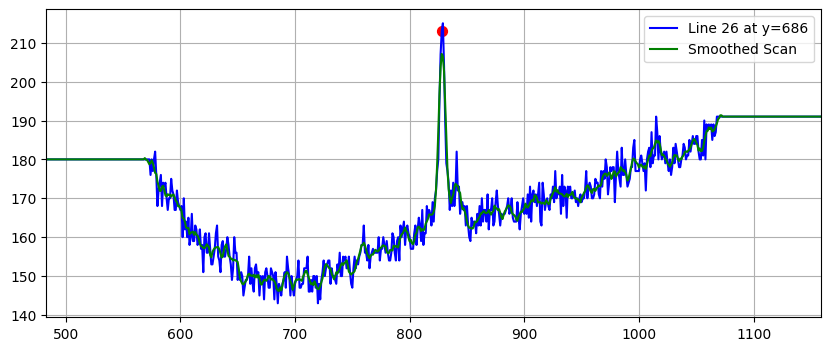

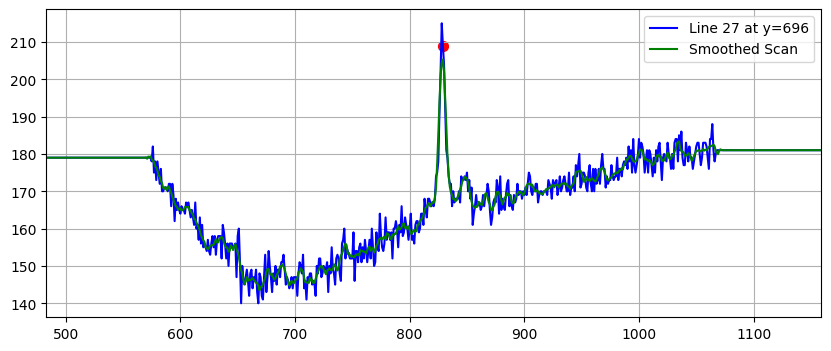

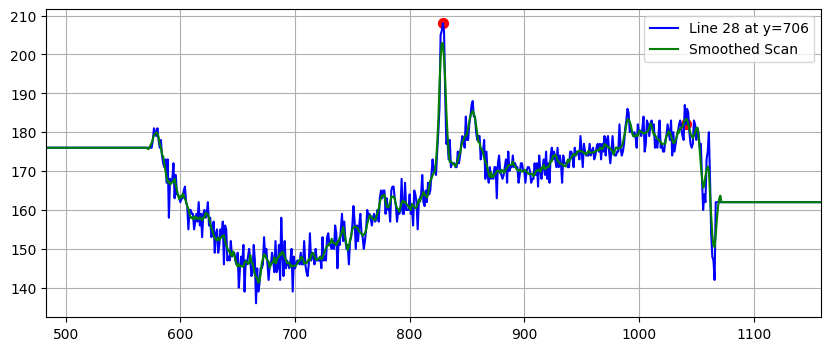

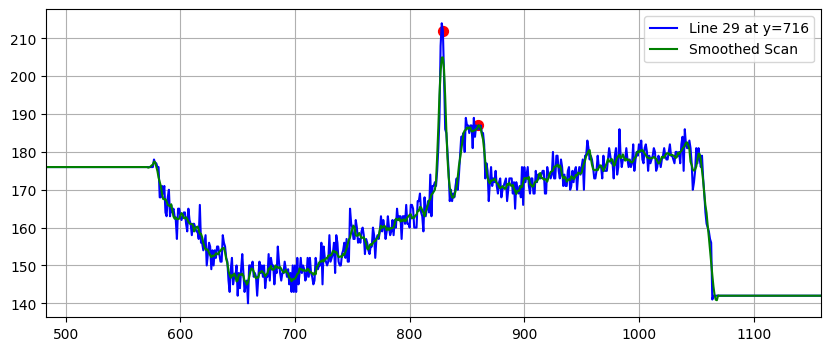

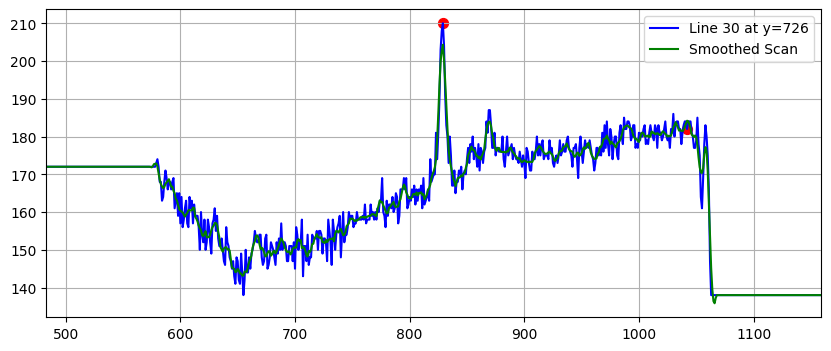

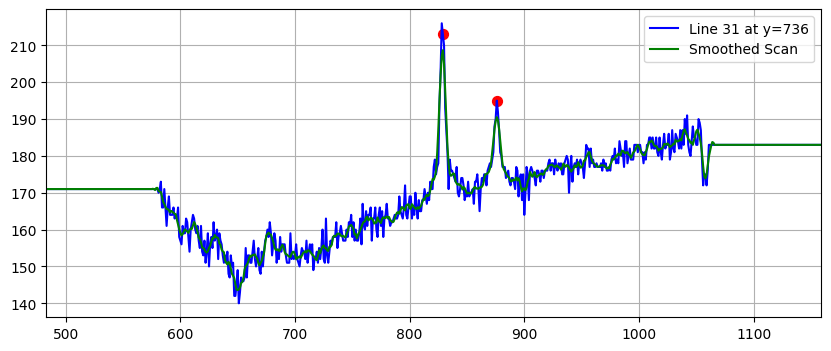

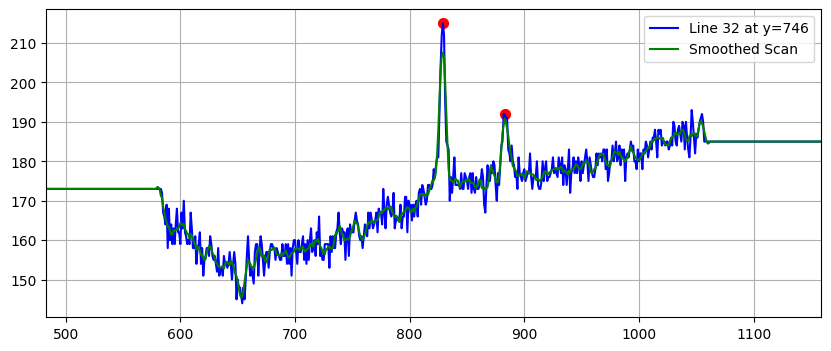

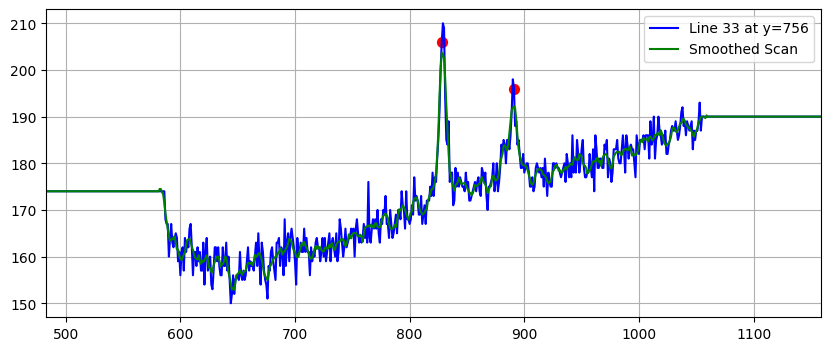

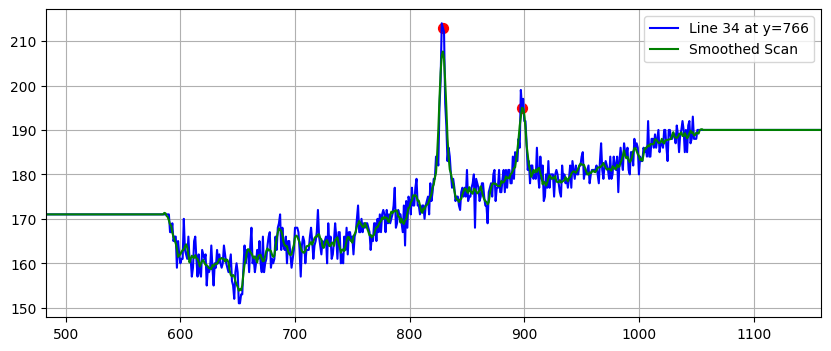

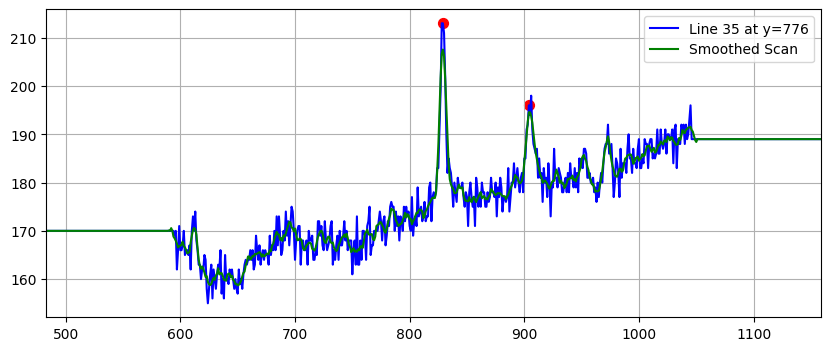

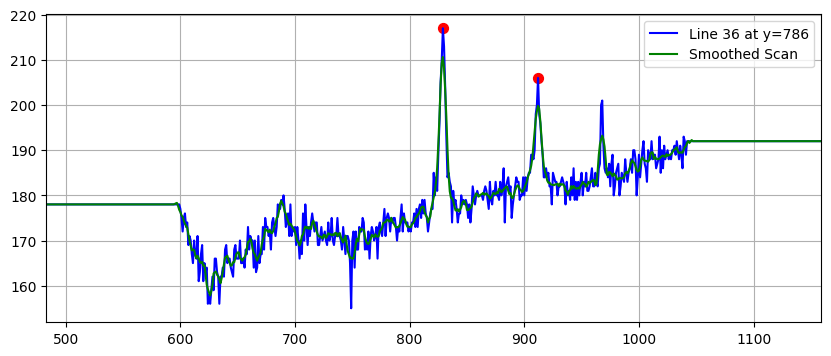

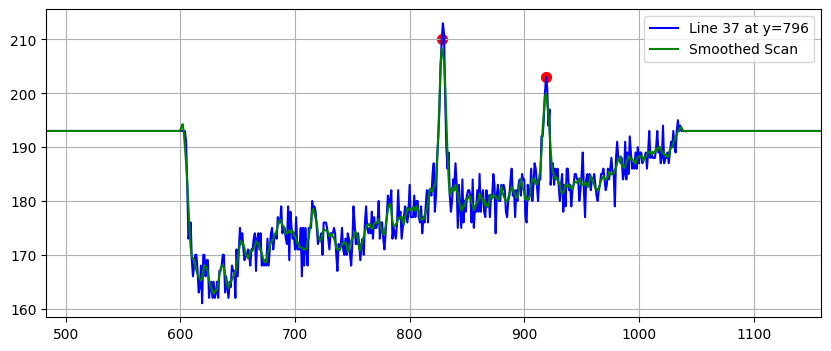

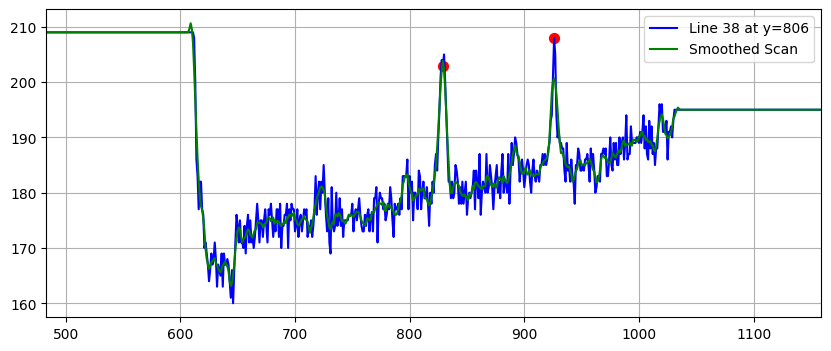

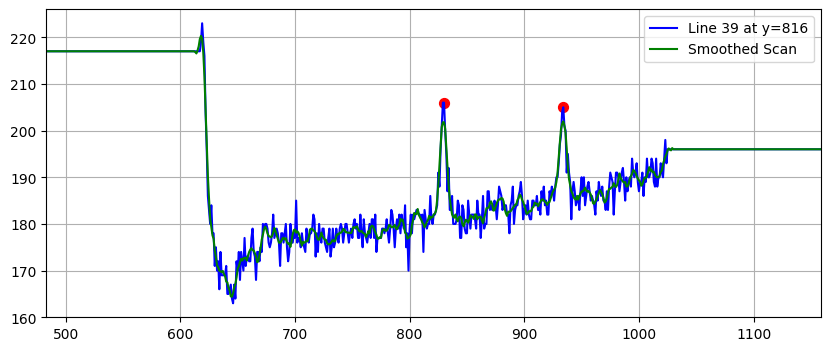

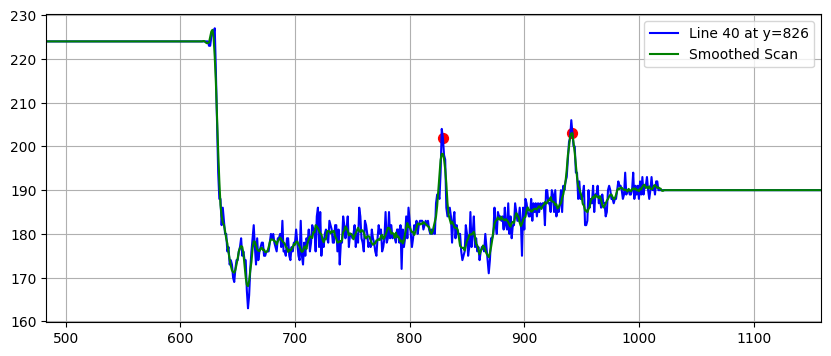

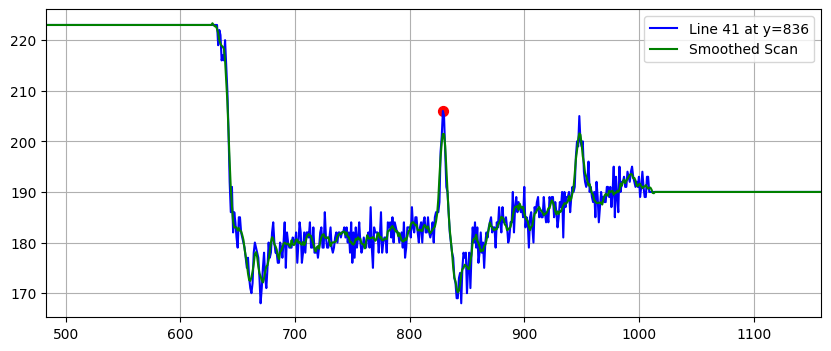

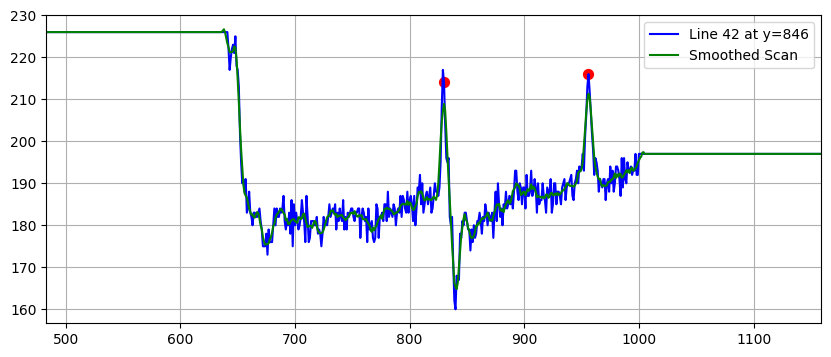

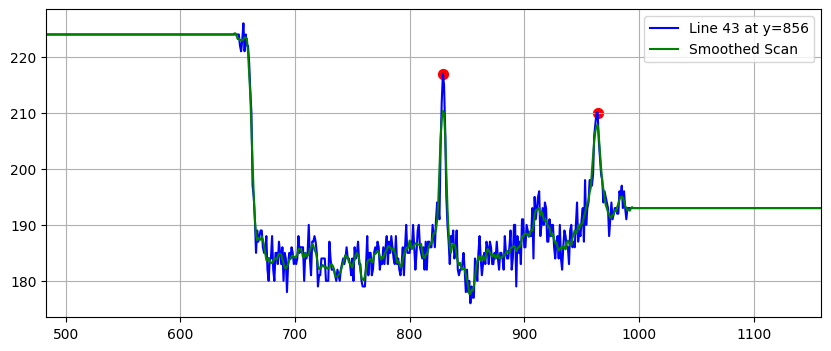

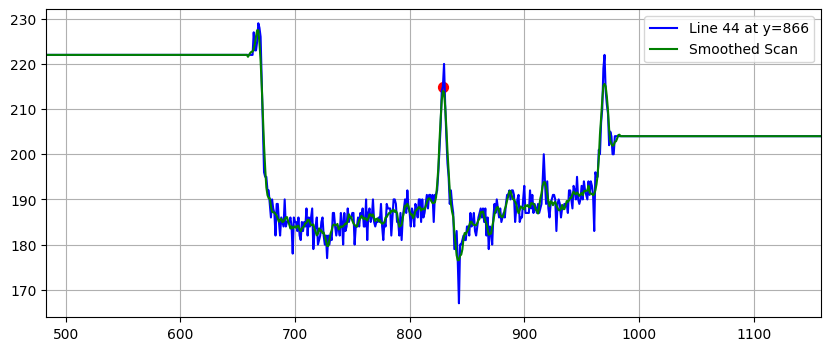

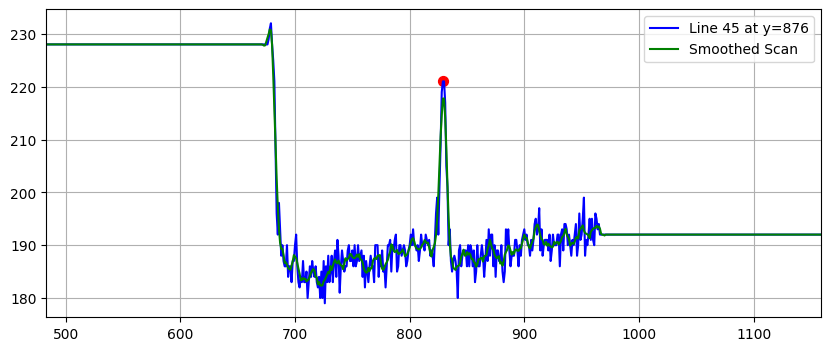

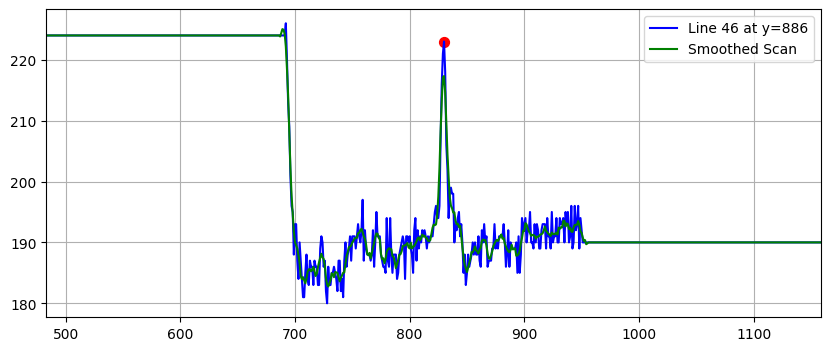

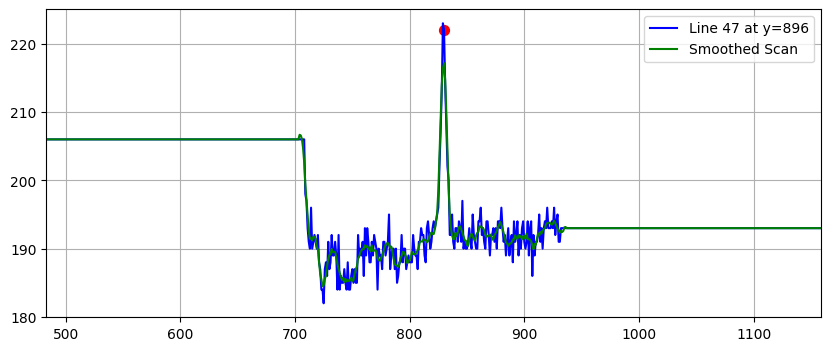

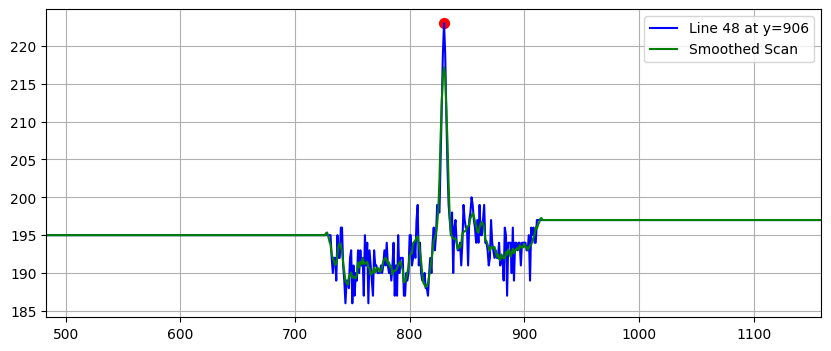

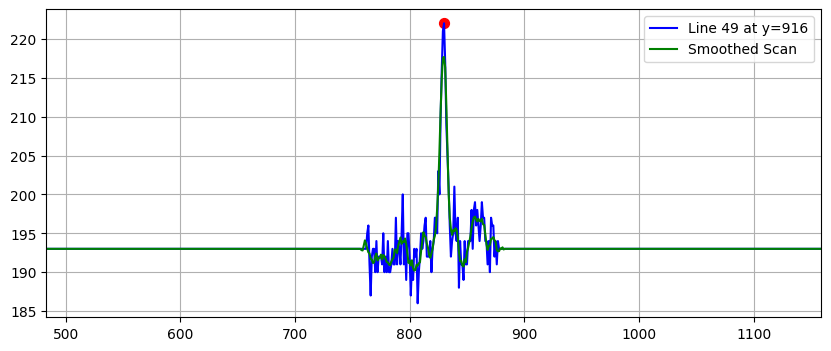

In [188]:
img_number="00026"

image_file_name=f"C:\\Users\\Jason.Bane\\Documents\\Nautilus\\DOE_stage\\code_trials\\images\\Image{img_number}.BMP"

image = cv2.imread(image_file_name)


horizontal_scan_for_center_peaks(image, resolution=10,  plot=2, verbose=True)

In [179]:
#veritcal scan function to find peaks
def vertical_scan_for_center_peaks(image, resolution, center_info=None, plot=1, verbose=False):
    
    #check if image is color or grayscale
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    
    if center_info is None:
        print("No center info provided.")
        edges=aex.horizontal_edges(gray_image, resolution=10, plot=0, verbose=False)
        center_info =aex.Center_Radius_iterations(edges, plot=False, verbose=False)

    cx, cy, r, rms = center_info[:4]
    inner_circle_rad=   r-91
    H_limit = [int(cx-inner_circle_rad), int(cx+inner_circle_rad)]
    V_limit = [int(cy-inner_circle_rad), int(cy+inner_circle_rad)]

    Horizontal_limits = [int(cx-r),int(cx+r)]
    Vertical_limits = [int(cy-r),int(cy+r)]

    

    if plot:
      fig,ax = plt.subplots(figsize=(6,10))
      ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      ax.plot(cx, cy, 'ro', label='Circle Center')
      inner_circle = plt.Circle((cx, cy), inner_circle_rad, color='blue',
                          fill=False, linestyle='--', linewidth=1, label='Inner Boundary')
      ax.add_artist(inner_circle) 
      ax.grid()


    All_peaks = []
    # start scanning lines
    for j,x in enumerate(range(H_limit[0],H_limit[1], resolution)):
        # if j<22 or j>29:
        #     continue
        if verbose:
            print(f"Line {j} at x={x}")

        line_scan = np.max(gray_image[:, x])-gray_image[:,x]

        # calculate top and bottom limits for the line scan useing circle equation

        square_diff =(np.ceil(inner_circle_rad**2) - (np.floor(x - cx))**2)
        if square_diff <= 0:
            if verbose:
                print(f"Skipping line {j} at x={x} - outside inner circle")
            continue

        top_most = int(cy - np.sqrt(square_diff))
        bottom_most = int(cy + np.sqrt(square_diff))

        line_scan[:top_most] = line_scan[top_most]
        line_scan[bottom_most:] =     line_scan[bottom_most]

        smooth_scan = scipy.signal.savgol_filter(line_scan, window_length=15, polyorder=3)


        
        if plot:
            ax.vlines(x, V_limit[0], V_limit[1],
                    colors='red', linestyles='dashed', linewidth=1)

        
        if plot > 1:
            
            fig2,ax2 = plt.subplots(figsize=(10,4))
            ax2.plot(line_scan, color="blue",label=f'Line {j} at x={x}')
            ax2.plot(smooth_scan, color="green",label='Smoothed Scan')
            ax2.grid() 
            ax2.legend()
            ax2.set_xlim(Vertical_limits)


        peaks=[]

        peaks,peak_props = scipy.signal.find_peaks(smooth_scan,
                                                width=[3,45],
                                                prominence=14.5,
                                                    height=1)

        # peaks1,peak_props1 = scipy.signal.find_peaks(smooth_scan,
        #                                         width=[1,85],
        #                                         prominence=4,
        #                                         threshold=1,
        #                                             height=1)





        if verbose:
            print(f"  Found {len(peaks)} peaks at x-positions: {peaks}") 
            for key in peak_props:
                print(f"    {key}: {peak_props[key]}")  

        # print(peaks1)
        # for key in peak_props1:
        #     print(f"    {key}: {peak_props1[key]}")


        if len(peaks) > 0:
            if plot > 1:
                ax2.scatter(peaks, line_scan[peaks], color='red', s=50, label='Detected Peaks')
            if plot >= 1:
                ax.scatter(np.full_like(peaks, x), peaks, color='cyan', s=20, label='Detected Peaks')
        # if len(peaks1) > 0:
        #     ax2.scatter(peaks1, smooth_scan[peaks1], color='red', s=50, label='All Detected Peaks')
            
        #If more then two peaks are found pick the best two based on prominence
        if len(peaks) > 2:
            prominences = peak_props['prominences']
            top_two_indices = np.argsort(prominences)[-2:]
            peaks = peaks[top_two_indices]


        All_peaks.append(np.column_stack((np.full_like(peaks, x), peaks)))

    return np.vstack(All_peaks)
            




No center info provided.


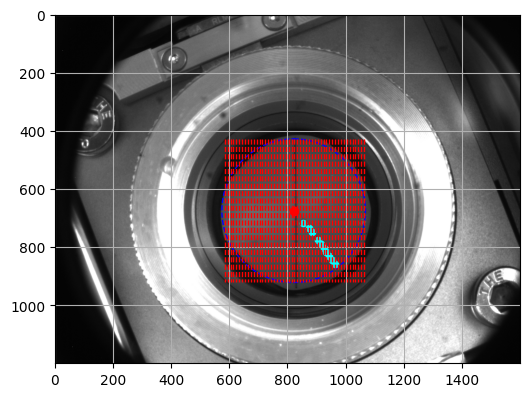

In [182]:
Vertical_scan = vertical_scan_for_center_peaks(image, resolution=10, plot=1, verbose=False)